In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from tqdm import tqdm

import pandas as pd
import numpy as np 
import os
import os.path as osp
import pandas as pd

from rdkit.Chem import rdmolops
from scipy.sparse import coo_matrix

from rdkit import Chem 
import random
import networkx as nx
import matplotlib.pyplot as plt

from captum.attr import Saliency, IntegratedGradients


In [2]:
 
import torch
from torch.nn import Linear
import torch.nn.functional as F



In [3]:
from torch_geometric.nn import GraphConv, global_add_pool
from torch_geometric.data import DataLoader
from torch_geometric.data import Dataset, Data, download_url 
from torch_geometric.utils import to_networkx

c:\Users\agavr\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\agavr\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [4]:
dataset = 'data/raw/updated_only_smiles.csv'
dataset_working_smiles = 'data/raw/working_smiles.csv'

df = pd.read_csv(dataset_working_smiles)
print(df.head()) 
df.shape

  DrugBank ID          Name  \
0     DB00006   Bivalirudin   
1     DB00007    Leuprolide   
2     DB00014     Goserelin   
3     DB00027  Gramicidin D   
4     DB00035  Desmopressin   

                                         Description   State  \
0  Bivalirudin is a synthetic 20 residue peptide ...   solid   
1  Leuprolide is a synthetic 9-residue peptide an...   solid   
2  Goserelin is a synthetic hormone. In men, it s...   solid   
3  Gramcidin D is a heterogeneous mixture of thre...  liquid   
4  Desmopressin (dDAVP), a synthetic analogue of ...   solid   

                      Groups  \
0  approved; investigational   
1  approved; investigational   
2                   approved   
3                   approved   
4                   approved   

                                          Categories  \
0  Amino Acids, Peptides, and Proteins; Anticoagu...   
1  Adrenal Cortex Hormones; Agents Causing Muscle...   
2  Adrenal Cortex Hormones; Amino Acids, Peptides...   
3  Amino Ac

(11773, 11)

In [5]:
label_counts = df['Doping'].value_counts()

count_0 = label_counts.get(0, 0) 
count_1 = label_counts.get(1, 0)  

total_count = df.shape[0]
unlabeled_count = total_count - (count_0 + count_1)

(count_0, count_1, unlabeled_count)


(11156, 617, 0)

In [16]:

df['Categories'] = df['Categories'].fillna('')
# Initialize a dictionary to hold the grouped drugs
grouped_drugs = {}

all_categories = set()
for categories in df['Categories']:
    all_categories.update(category.strip() for category in categories.split(';'))

# Initialize a dictionary to hold the grouped drugs
grouped_drugs = {category: [] for category in all_categories}

# Iterate through each row in the dataframe and group drugs by categories
for index, row in df.iterrows():
    drug_name = row['Name']
    categories = [category.strip() for category in row['Categories'].split(';')]
    for category in categories:
        if category in grouped_drugs:
            grouped_drugs[category].append(drug_name)

# Convert the grouped drugs dictionary to a DataFrame for better visualization
# Convert the grouped drugs dictionary to a DataFrame for better visualization
grouped_drugs_list = [(k, ', '.join(v)) for k, v in grouped_drugs.items()]
grouped_drugs_list.sort()  # Sort the list of tuples by the category

grouped_drugs_df = pd.DataFrame(grouped_drugs_list, columns=['Category', 'Drugs'])

# Save the DataFrame to a CSV file
grouped_drugs_df.to_csv('grouped_drugs.csv', index=False)

# Display the DataFrame
print(grouped_drugs_df)

                                               Category  \
0                                                         
1                                1-Carboxyglutamic Acid   
2                             11-Hydroxycorticosteroids   
3     11-beta-Hydroxysteroid Dehydrogenase Type 1, a...   
4                       14-alpha Demethylase Inhibitors   
...                                                 ...   
3553    p21-Activated Kinases, antagonists & inhibitors   
3554              p38 Mitogen-Activated Protein Kinases   
3555  p38 Mitogen-Activated Protein Kinases, antagon...   
3556                                para-Aminobenzoates   
3557   rho-Associated Kinases, antagonists & inhibitors   

                                                  Drugs  
0     Indecainide, Kava, Quinidine barbiturate, 3-Me...  
1                         gamma-carboxy-L-glutamic acid  
2     Fludrocortisone, Hydrocortisone, Aldosterone, ...  
3                                     ABT-384, AZD-4017  
4

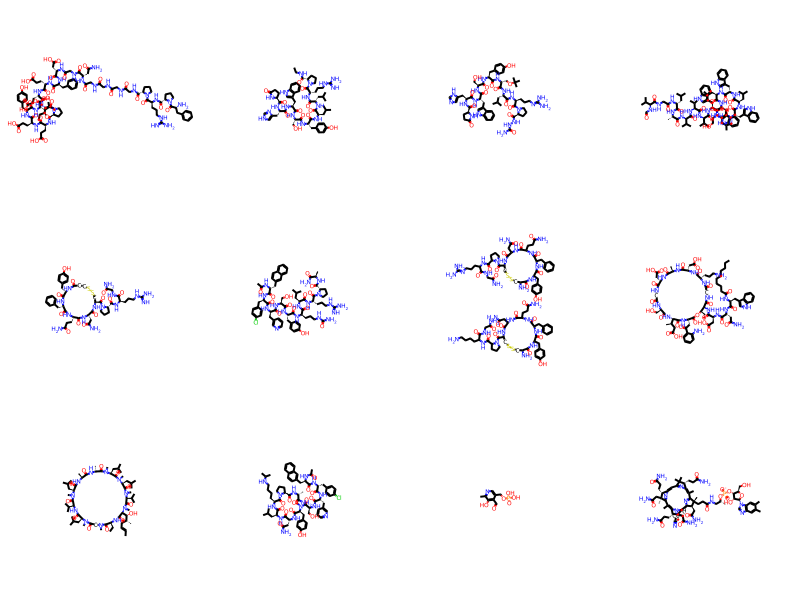

In [6]:
df['SMILES'] = df['SMILES'].astype(str)
sample_smiles = df["SMILES"][0:12].values
sample_mols = [Chem.MolFromSmiles(smiles)for \
              smiles in sample_smiles]
grid = Draw.MolsToGridImage(sample_mols,
                           molsPerRow = 4,
                           subImgSize = (200,200))
grid

In [6]:
import jax

In [7]:
import deepchem as dc

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'haiku'


In [84]:

df1 =  pd.read_csv('data//raw/working_smiles.csv')
df2 = pd.read_csv('smiles.csv')

def compare_drug_dataframes(df1, df2):
    # Filter df1 for drugs with a 'Doping' label of 1
    doped_drugs = df1[df1['Doping'] == 1]
    
    # Find DrugBank IDs in df1 not in df2
    missing_drugs = doped_drugs[~doped_drugs['DrugBank ID'].isin(df2['DrugBank ID'])]
    missing_drug_ids = missing_drugs['DrugBank ID'].tolist()
    
    # Find the DrugBank IDs in df1 that are also in df2
    found_drugs = doped_drugs[doped_drugs['DrugBank ID'].isin(df2['DrugBank ID'])]
    
 # Extract 'Similar Structures' and 'DrugBank ID' info for drugs found in df2
    similarities = df2[df2['DrugBank ID'].isin(found_drugs['DrugBank ID'])][['DrugBank ID', 'Similar Structure']]
    
    # Assuming 'Similar Structures' column contains lists or comma-separated values; if not, adjust parsing accordingly
    # Convert any non-list column to a list format if needed
    similarities['Similar Structure'] = similarities['Similar Structure'].apply(lambda x: x.split(',') if type(x) == str else x)
    
    # Save the 'Similar Structures' and 'DrugBank ID' info to a new CSV file
    similarities.to_csv('Similarities.csv', index=False)
    
    return missing_drug_ids

# Usage of the function
# Assuming df1 and df2 are your dataframes loaded into the environment
missing_drug_ids = compare_drug_dataframes(df1, df2)
print(missing_drug_ids)


[]


In [25]:
                                                #########Check the molecule status################

def get_molecule_at_index(df, index):
    try:
        molecule = df.iloc[index]
        return molecule
    except IndexError:
        return f"Error: Index {index} is out of range for the DataFrame."
    except Exception as e:
        return f"An error occurred: {e}"

index = 642
molecule_at_index_642 = get_molecule_at_index(df, index)

print(molecule_at_index_642)

DrugBank ID                                                    DB00761
Name                                                Potassium chloride
Description          A white crystal or crystalline powder used as ...
State                                                            solid
Groups                                             approved; withdrawn
Categories           Agents causing hyperkalemia; Alimentary Tract ...
ATC Codes            A12BA51: Potassium; POTASSIUM; MINERAL SUPPLEM...
Targets              BE0000281: Solute carrier family 12 member 2 |...
SMILES                                                      [Cl-].[K+]
Molecular Formula                                                  ClK
Doping                                                               0
Name: 642, dtype: object


In [57]:
import re

similar = pd.read_csv("Similarities.csv")
# Extract unique DrugBank IDs
unique_drugbank_ids = set(similar['DrugBank ID'])
for similar_structures in similar['Similar Structure']:
    similar_ids = re.findall(r"'(.*?)'", similar_structures)
    unique_drugbank_ids.update(similar_ids)

# Convert to a sorted list
unique_drugbank_ids = sorted(unique_drugbank_ids)

# Load the doping status data
doping_df = pd.read_csv('data\\raw\working_smiles.csv')

# Filter the doping status for the unique DrugBank IDs
status_df = doping_df[doping_df['DrugBank ID'].isin(unique_drugbank_ids)][['DrugBank ID', 'Doping']]

# Save the result to a CSV file
status_df.to_csv('status.csv', index=False)
print(len(unique_drugbank_ids))

status_df


1784
Number of drugs labeled 1: 620
Number of drugs labeled 0: 10
DrugBank IDs labeled 0: ['DB00396', 'DB00397', 'DB00704', 'DB00843', 'DB01384', 'DB02042', 'DB02202', 'DB02548', 'DB08308', 'DB14640']


In [58]:
smiles_df = pd.read_csv("smiles.csv")
# Check for non-empty Similar Structure entries
non_empty_similar_structure = smiles_df['Similar Structure'].notna() & (smiles_df['Similar Structure'] != '[]')
empty_similar_structure = ~non_empty_similar_structure

# Count the number of DrugBank IDs with and without Similar Structure information
count_with_info = non_empty_similar_structure.sum()
count_without_info = empty_similar_structure.sum()

print(f"Number of DrugBank IDs with Similar Structure information: {count_with_info}")
print(f"Number of DrugBank IDs without Similar Structure information: {count_without_info}")

Number of DrugBank IDs with Similar Structure information: 11936
Number of DrugBank IDs without Similar Structure information: 763


In [63]:

working_smiles_df = pd.read_csv('data\\raw\working_smiles.csv')
smiles_df = pd.read_csv('smiles.csv')

# Merge the dataframes on the DrugBank ID column
merged_df = pd.merge(working_smiles_df[['DrugBank ID', 'Doping']], smiles_df[['DrugBank ID', 'Similar Structure']], on='DrugBank ID', how='left')

# Save the merged dataframe as merge.csv
merged_df.to_csv('merge.csv', index=False)
count_doping_1 = merged_df[merged_df['Doping'] == 1].shape[0]
count_doping_0 = merged_df[merged_df['Doping'] == 0].shape[0]

print(f"Number of drugs labeled 1: {count_doping_1}")
print(f"Number of drugs labeled 0: {count_doping_0}")
print(len(merged_df))
# Display the merged dataframe
merged_df


Number of drugs labeled 1: 620
Number of drugs labeled 0: 11153
11773


,DrugBank ID,Doping,Similar Structure
0,DB00006,0,"DB00006, DB16152, DB05660, DB15231, DB11890, D..."
1,DB00007,1,"DB00007, DB06825, DB11510, DB00666, DB18169, D..."
2,DB00014,1,"DB00014, DB06719, DB00644, DB00007, DB06825, D..."
3,DB00027,0,"DB00027, DB12748, DB14777, DB12054, DB18252, D..."
4,DB00035,1,"DB00035, DB14642, DB13798, DB00067, DB09059, D..."
...,...,...,...
11768,DB18708,0,DB18708
11769,DB18709,0,DB18709
11770,DB18711,0,"DB18711, DB07125, DB08004, DB04715, DB12494, D..."
11771,DB18715,0,"DB18715, DB15227"


In [80]:
# Filter for DrugBank IDs labeled 0
labeled_0_df = merged_df[merged_df['Doping'] == 0]

atleast_one_list = []

# Iterate through the Similar Structure list for each DrugBank ID labeled 0
for index, row in labeled_0_df.iterrows():
    drug_id = row['DrugBank ID']
    similar_structure = row['Similar Structure']
    
    if pd.notna(similar_structure) and similar_structure != '[]':
        # Remove brackets and split by comma
        similar_ids = [id.strip().strip("'") for id in similar_structure.strip('[]').split(',')]
        
        # Get the doping labels for these similar DrugBank IDs
        labels = working_smiles_df[working_smiles_df['DrugBank ID'].isin(similar_ids)][['DrugBank ID', 'Doping']]
        
        # Check if there's at least one drug labeled 1
        if any(labels['Doping'] == 1):
            atleast_one_list.append(drug_id)

# Create a dataframe from the list of DrugBank IDs with at least one similar drug labeled 1
atleast_one = pd.DataFrame(atleast_one_list, columns=['DrugBank ID'])
atleast_one['Doping'] = 0

# Save the resulting dataframe as atleast_one.csv
atleast_one.to_csv('atleast_one.csv', index=False)

# Print the resulting dataframe
print(atleast_one)

    DrugBank ID  Doping
0       DB00006       0
1       DB00027       0
2       DB00050       0
3       DB00080       0
4       DB00106       0
..          ...     ...
741     DB18539       0
742     DB18540       0
743     DB18541       0
744     DB18542       0
745     DB18634       0

[746 rows x 2 columns]


In [72]:
atleast_one_list = []

# Iterate through the Similar Structure list for each DrugBank ID labeled 0
for index, row in labeled_0_df.iterrows():
    drug_id = row['DrugBank ID']
    similar_structure = row['Similar Structure']
    
    if pd.notna(similar_structure) and similar_structure != '[]':
        # Remove brackets and split by comma
        similar_ids = [id.strip().strip("'") for id in similar_structure.strip('[]').split(',')]
        
        # Get the doping labels for these similar DrugBank IDs
        labels = working_smiles_df[working_smiles_df['DrugBank ID'].isin(similar_ids)][['DrugBank ID', 'Doping']]
        
        # Check if there's at least one drug labeled 1
        if any(labels['Doping'] == 1):
            atleast_one_list.append((drug_id, labels))

# Write the output to a text file
with open('atleast_one.txt', 'w') as f:
    for drug_id, labels in atleast_one_list:
        f.write(f"DrugBank ID: {drug_id}\n")
        f.write(labels.to_string(index=False))
        f.write("\n\n")

# Print the resulting dataframe
for drug_id, labels in atleast_one_list:
    print(f"DrugBank ID: {drug_id}")
    print(labels)
    print("\n")

DrugBank ID: DB00006
      DrugBank ID  Doping
0         DB00006       0
4         DB00035       1
3261      DB03632       0
4504      DB05034       0
4663      DB05625       0
4674      DB05660       0
4691      DB05724       0
4852      DB06260       0
7123      DB08890       0
7258      DB09059       0
7948      DB11720       0
8090      DB11890       0
8179      DB11996       0
8288      DB12126       0
9622      DB13742       0
9677      DB13798       0
10159     DB14786       0
10171     DB14806       0
10397     DB15195       0
10422     DB15231       0
10450     DB15272       0
10493     DB15340       0
10511     DB15366       0
10640     DB15636       0
10934     DB16146       0
10937     DB16152       0
11121     DB16687       0
11430     DB17352       0
11686     DB18283       0
11762     DB18634       0


DrugBank ID: DB00027
      DrugBank ID  Doping
3         DB00027       0
1982      DB02255       0
4448      DB04894       0
5005      DB06610       0
5026      DB06645   

In [86]:
all_one_list = []

# Iterate through the Similar Structure list for each DrugBank ID labeled 0
for index, row in merged_df.iterrows():
    drug_id = row['DrugBank ID']
    similar_structure = row['Similar Structure']
    
    if pd.notna(similar_structure) and similar_structure != '[]':
        # Remove brackets and split by comma
        similar_ids = [id.strip().strip("'") for id in similar_structure.strip('[]').split(',')]
        
        # Get the doping labels for these similar DrugBank IDs
        labels = working_smiles_df[working_smiles_df['DrugBank ID'].isin(similar_ids)][['DrugBank ID', 'Doping']]
        drug_doping_label = working_smiles_df.loc[working_smiles_df['DrugBank ID'] == drug_id, 'Doping'].values[0]

        # Check if there's at least one drug labeled 1
        if any(labels['Doping'] == 1):
            all_one_list.append((drug_id, drug_doping_label))

# Create a dataframe from the list of DrugBank IDs with at least one similar drug labeled 1
all_one = pd.DataFrame(all_one_list, columns=['DrugBank ID', 'Doping'])
all_one = all_one.merge(working_smiles_df[['DrugBank ID', 'SMILES']], on='DrugBank ID', how='left')


# Save the resulting dataframe as atleast_one.csv
all_one.to_csv('all_one.csv', index=False)

# Print the resulting dataframe
print(all_one)

     DrugBank ID  Doping                                             SMILES
0        DB00006       0  CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...
1        DB00007       1  CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...
2        DB00014       1  CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...
3        DB00027       0  CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...
4        DB00035       1  NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...
...          ...     ...                                                ...
1361     DB18540       0  [H][C@@]1(O[C@@H]2[C@@H](CO[C@@H]3O[C@H](CO)[C...
1362     DB18541       0  [H][C@@]1(O[C@H]2[C@H](O)[C@@H](CO)O[C@@]([H])...
1363     DB18542       0  [H][C@@]1(O[C@H]2[C@H](O)[C@@H](CO)O[C@@]([H])...
1364     DB18632       1  CC1=CNC(=N1)C1=CC=C(C2=C1C(=O)NC2)C1=CC=C(NC(=...
1365     DB18634       0  CC[C@H](C)[C@H](NC(=O)[C@H](CO)NC(=O)[C@H](CC(...

[1366 rows x 3 columns]


In [77]:
all_one_list = []

# Iterate through the Similar Structure list for each DrugBank ID labeled 0
for index, row in merged_df.iterrows():
    drug_id = row['DrugBank ID']
    similar_structure = row['Similar Structure']
    
    if pd.notna(similar_structure) and similar_structure != '[]':
        # Remove brackets and split by comma
        similar_ids = [id.strip().strip("'") for id in similar_structure.strip('[]').split(',')]
        
        # Get the doping labels for these similar DrugBank IDs
        labels = working_smiles_df[working_smiles_df['DrugBank ID'].isin(similar_ids)][['DrugBank ID', 'Doping']]
        
        # Check if there's at least one drug labeled 1
        if any(labels['Doping'] == 1):
            all_one_list.append((drug_id, labels))

# Write the output to a text file
with open('all_one.txt', 'w') as f:
    for drug_id, labels in all_one_list:
        f.write(f"DrugBank ID: {drug_id}\n")
        f.write(labels.to_string(index=False))
        f.write("\n\n")

# Print the resulting dataframe
for drug_id, labels in all_one_list:
    print(f"DrugBank ID: {drug_id}")
    print(labels)
    print("\n")

DrugBank ID: DB00006
      DrugBank ID  Doping
0         DB00006       0
4         DB00035       1
3261      DB03632       0
4504      DB05034       0
4663      DB05625       0
4674      DB05660       0
4691      DB05724       0
4852      DB06260       0
7123      DB08890       0
7258      DB09059       0
7948      DB11720       0
8090      DB11890       0
8179      DB11996       0
8288      DB12126       0
9622      DB13742       0
9677      DB13798       0
10159     DB14786       0
10171     DB14806       0
10397     DB15195       0
10422     DB15231       0
10450     DB15272       0
10493     DB15340       0
10511     DB15366       0
10640     DB15636       0
10934     DB16146       0
10937     DB16152       0
11121     DB16687       0
11430     DB17352       0
11686     DB18283       0
11762     DB18634       0


DrugBank ID: DB00007
      DrugBank ID  Doping
1         DB00007       1
2         DB00014       1
529       DB00644       1
551       DB00666       1
1138      DB01284   

In [16]:
print(dataset[23].edge_index.t())
print(dataset[23].x)
print(dataset[23].edge_attr)
print(dataset[23].y)

tensor([[0, 1],
        [1, 0],
        [1, 2],
        [2, 1],
        [2, 3],
        [3, 2],
        [3, 4],
        [4, 3],
        [3, 5],
        [5, 3],
        [1, 6],
        [6, 1],
        [6, 7],
        [7, 6],
        [6, 8],
        [8, 6]])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,

In [15]:
from torch_geometric.loader import DataLoader  # Import from torch_geometric

test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

In [10]:

#############################################################3
##########THIS WORKS##########################################################

import pandas as pd
import torch
from torch_geometric.data import Dataset
import numpy as np 
import os
from tqdm import tqdm
import deepchem as dc
from rdkit import Chem
import random
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

class DopingDataset(Dataset):
    def __init__(self, root, filename, atom_map, test=False, transform=None, pre_transform=None):
        self.test = test
        self.filename = filename
        self.atom_map = atom_map
        super(DopingDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        return self.filename

    @property
    def processed_file_names(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        
    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        for index, row in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol = Chem.MolFromSmiles(row["SMILES"])
            if mol is None:
                print(f"Invalid SMILES string at index {index}: {row['SMILES']}")
                continue
            try:
                f = featurizer._featurize(mol)
                if len(f.edge_index) == 0 or f.edge_features is None or f.edge_features.size == 0:
                    print(f"No bonds found in molecule at index {index}: {row['SMILES']}")
                    continue
                data = f.to_pyg_graph()
                data.y = self._get_label(row["Doping"])
                data.smiles = row["SMILES"]
                data.atom_indices = [self.atom_map.index(atom.GetSymbol()) for atom in mol.GetAtoms()]
                if self.test:
                    torch.save(data, os.path.join(self.processed_dir, f'data_test_{index}.pt'))
                else:
                    torch.save(data, os.path.join(self.processed_dir, f'data_{index}.pt'))
            except Exception as e:
                print(f"Error processing molecule at index {index}: {e}")

    def _get_label(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        try:
            if self.test:
                data = torch.load(os.path.join(self.processed_dir, f'data_test_{idx}.pt'))
            else:
                data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))        
            return data
        except FileNotFoundError:
            print(f"File not found for index {idx}, skipping.")
            return None


In [45]:
def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.spring_layout(g)
    
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
        
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()

def to_molecule(data, atom_map):
    g = to_networkx(data, node_attrs=['x'])
   
    for u, node_data in g.nodes(data=True):
        atom_idx = data.atom_indices[u]
        node_data['name'] = atom_map[atom_idx]
        del node_data['x']
    return g

In [12]:
ATOM_MAP = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 
            'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'V', 'Cr', 
            'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 
            'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 
            'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 
            'Ba', 'La', 'Ce', 'Nd', 'Sm', 'Gd', 'Ho', 'Lu', 'Hf', 'Ta', 
            'W', 'Re', 'Os', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ra', 'Ac', 'Bk']

dataset = DopingDataset(root="data", filename="working_smiles.csv", atom_map=ATOM_MAP)

valid_data = [data for data in dataset if data is not None]

print(f"Number of valid data points: {len(valid_data)}")

Number of valid data points: 11773


SMILES formula: [H][C@@]12CC[C@](C)(O)[C@@]1(C)CC[C@@]1([H])[C@@]2([H])CC[C@@]2([H])CC(=O)OC[C@]12C


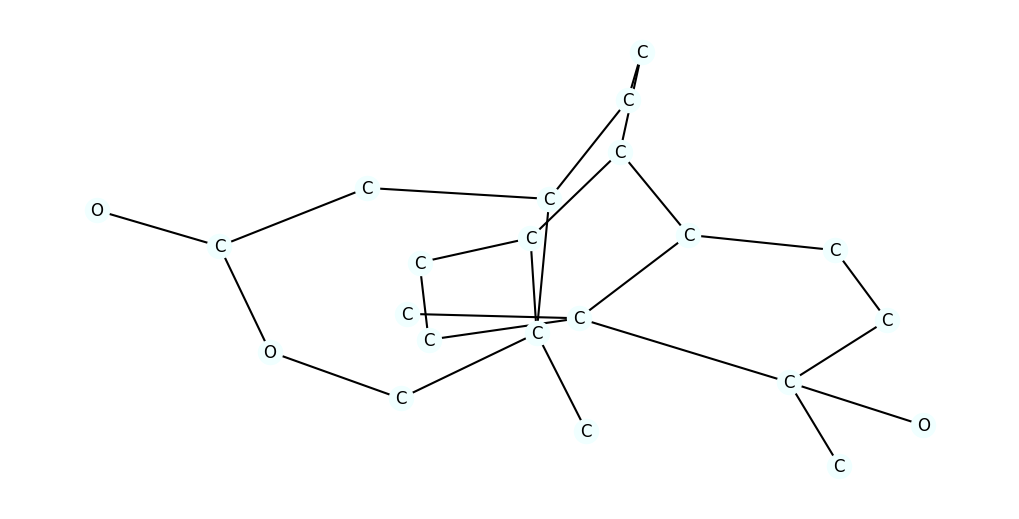

In [13]:
#data_sample = random.choice(valid_data)
data_sample = valid_data[507]
print(f"SMILES formula: {data_sample.smiles}")
mol = to_molecule(data_sample, ATOM_MAP)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

In [14]:
# import torch
# from torch.nn import Linear
# import torch.nn.functional as F
# from torch_geometric.nn import GraphConv, global_add_pool
# from torch_geometric.data import DataLoader

# Define the model
class Net(torch.nn.Module):
    def __init__(self, dim):
        super(Net, self).__init__()

        num_features = dataset.num_features
        self.dim = dim

        self.conv1 = GraphConv(num_features, dim)
        self.conv2 = GraphConv(dim, dim)
        self.conv3 = GraphConv(dim, dim)
        self.conv4 = GraphConv(dim, dim)
        self.conv5 = GraphConv(dim, dim)

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
        x = self.conv4(x, edge_index, edge_weight).relu()
        x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

# Custom DataLoader to skip missing files
class SafeDataLoader(DataLoader):
    def __iter__(self):
        for data in super().__iter__():
            if data is None:
                continue
            yield data


In [17]:
# Training and testing functions
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = SafeDataLoader(valid_data[:int(0.8*len(valid_data))], batch_size=32, shuffle=True)
test_loader = SafeDataLoader(valid_data[int(0.8*len(valid_data)):], batch_size=32, shuffle=False)

for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

c:\Users\agavr\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 001, Loss: 0.2980, Train Acc: 0.9479, Test Acc: 0.9465
Epoch: 002, Loss: 0.2172, Train Acc: 0.9479, Test Acc: 0.9465
Epoch: 003, Loss: 0.1955, Train Acc: 0.9479, Test Acc: 0.9465
Epoch: 004, Loss: 0.1825, Train Acc: 0.9503, Test Acc: 0.9456
Epoch: 005, Loss: 0.1750, Train Acc: 0.9487, Test Acc: 0.9461
Epoch: 006, Loss: 0.1709, Train Acc: 0.9480, Test Acc: 0.9465
Epoch: 007, Loss: 0.1587, Train Acc: 0.9479, Test Acc: 0.9465
Epoch: 008, Loss: 0.1570, Train Acc: 0.9487, Test Acc: 0.9469
Epoch: 009, Loss: 0.1560, Train Acc: 0.9541, Test Acc: 0.9503
Epoch: 010, Loss: 0.1450, Train Acc: 0.9568, Test Acc: 0.9478
Epoch: 011, Loss: 0.1427, Train Acc: 0.9580, Test Acc: 0.9512
Epoch: 012, Loss: 0.1336, Train Acc: 0.9571, Test Acc: 0.9486
Epoch: 013, Loss: 0.1438, Train Acc: 0.9583, Test Acc: 0.9550
Epoch: 014, Loss: 0.1385, Train Acc: 0.9580, Test Acc: 0.9456
Epoch: 015, Loss: 0.1277, Train Acc: 0.9599, Test Acc: 0.9537
Epoch: 016, Loss: 0.1265, Train Acc: 0.9591, Test Acc: 0.9537
Epoch: 0

In [31]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out

def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

In [32]:
from captum.attr import Saliency, IntegratedGradients
def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out

def explain(method, data, target=1):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    
    # Get influential edges
    edge_influence = [(u.item(), v.item(), val) for val, u, v in zip(edge_mask, *data.edge_index)]
    edge_influence.sort(key=lambda x: x[2], reverse=True)
    influential_edges = edge_influence[:10]  # Top 10 influential edges

    # Get influential nodes
    influential_nodes = set()
    for u, v, val in influential_edges:
        influential_nodes.add(u)
        influential_nodes.add(v)
    
    return edge_mask, influential_edges, influential_nodes


In [33]:
def explain(method, data, target=1):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    print("Initial Input Mask:", input_mask)  # Prints the initial state of input_mask

    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
        print("Attributions from Integrated Gradients:", mask)  # Prints the attributions computed by IG

    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
        print("Attributions from Saliency:", mask)  # Prints the attributions computed by Saliency

    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    print("Absolute Edge Mask:", edge_mask)  # Prints the absolute values of the mask

    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
        print("Normalized Edge Mask:", edge_mask)  # Prints the normalized edge mask

    return edge_mask


SMILES formula: OC1(CCN(CCCC(=O)C2=CC=C(F)C=C2)CC1)C1=CC=C(Cl)C=C1
Initial Input Mask: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], requires_grad=True)
Attributions from Integrated Gradients: tensor([ 9.5829e-06,  9.5511e-06,  7.0303e-06, -1.1026e-05, -6.3379e-05,
        -6.8253e-06, -1.7745e-05,  5.0968e-05,  3.5254e-05, -2.9511e-05,
         3.7360e-06, -7.1618e-05,  3.3112e-06,  8.0688e-06, -4.8624e-05,
         4.8453e-06, -9.7510e-05, -5.3435e-05,  3.3956e-05, -2.0819e-06,
        -2.1775e-05, -6.7417e-06, -5.3321e-05, -5.9237e-05,  3.6617e-05,
         2.7677e-05, -1.0014e-04,  2.6987e-04,  2.7677e-05,  3.6617e-05,
        -5.9237e-05, -5.3321e-05,  5.0968e-05, -1.7745e-05, -6.8253e-06,
        -6.3379e-05, -3.5639e-06,  2.0239e-05, -3.1175e-07,  3.8256e-06,
        -9.7

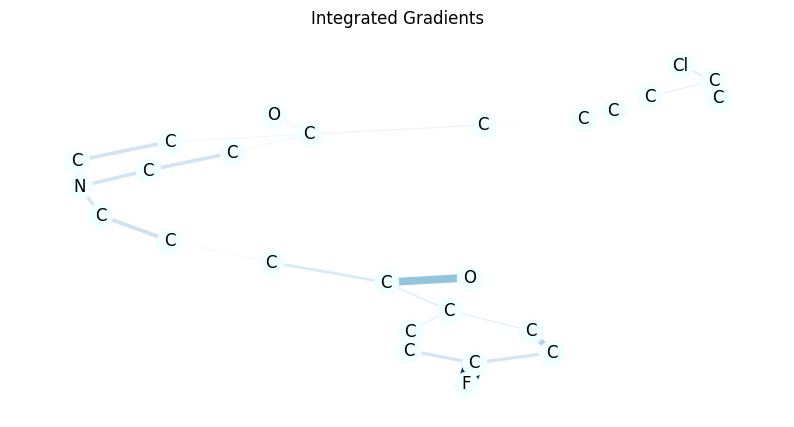

Initial Input Mask: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], requires_grad=True)
Attributions from Saliency: tensor([3.7114e-04, 3.0707e-04, 2.7827e-04, 1.0259e-04, 6.6919e-04, 1.5667e-04,
        3.0727e-04, 4.6228e-04, 5.6706e-04, 4.4208e-04, 1.4405e-04, 1.0198e-03,
        1.8697e-04, 2.3746e-05, 7.4963e-04, 3.6702e-04, 3.8133e-05, 2.5354e-04,
        2.5229e-04, 3.4494e-04, 1.5552e-04, 2.5597e-04, 3.0314e-04, 4.4153e-04,
        5.0327e-04, 2.8088e-06, 1.9754e-03, 4.7365e-04, 2.8088e-06, 5.0327e-04,
        4.4153e-04, 3.0314e-04, 4.6228e-04, 3.0727e-04, 1.5667e-04, 6.6919e-04,
        1.1316e-05, 5.4499e-05, 1.6665e-06, 7.0072e-05, 4.5831e-06, 8.4165e-07,
        1.3440e-04, 2.5937e-06, 1.6836e-04, 5.6723e-05, 2.5937e-06, 1.3440e-04,
        8.4165e-07, 4.5831e-06, 1.0

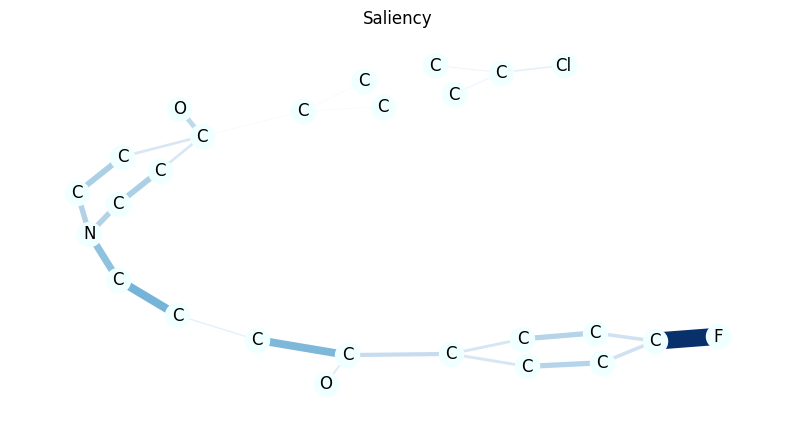

In [38]:
import random
from collections import defaultdict

# Function to aggregate edge directions
def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

# Custom function to filter out missing data
def filter_existing_data(dataset):
    existing_data = []
    for i in range(len(dataset)):
        try:
            data = dataset.get(i)
            if data is not None:
                existing_data.append(data)
        except FileNotFoundError:
            print(f"File not found for index {i}, skipping.")
    return existing_data

# Filter test_dataset to only include existing data
filtered_test_dataset = filter_existing_data(test_dataset)

# Sample a molecule once from the filtered test dataset
data = random.choice([t for t in filtered_test_dataset if not t.y.item()])
mol = to_molecule(data, ATOM_MAP)
print(f"SMILES formula: {data.smiles}")

# Use the same molecule for both methods
for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)


SMILES formula: CC1=C2NC(=O)C3=C(N=CC=C3)N(C3CC3)C2=NC=C1
Initial Input Mask: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
Attributions from Integrated Gradients: tensor([ 8.7581, 12.9100,  9.5823,  6.2652, 22.5280,  5.4321, 18.0124, 20.4163,
        19.5241,  2.7020,  5.6383,  8.8287,  9.9142,  6.4733, 15.1961,  3.3968,
        16.2571, 15.0770, 24.7032, 35.4072, 27.9565, 24.9560, 12.2855,  8.0771,
         9.7203,  4.4242, 12.7596,  5.9734, 15.6180, 15.6180,  9.0746, 12.4227,
        15.5554,  3.1218, 14.5323, 14.2868, 25.3517, 35.1800,  6.9577, 24.2005,
         8.1482, 10.5503,  8.3596, 22.6834,  5.9734, 12.7596],
       dtype=torch.float64, grad_fn=<AddBackward0>)
Absolute Edge Mask: [ 8.75805423 12.91000698  9.58231332  6.2651974  22.52800202  5.43210272
 18.01236411 20.41629725 19.52411046  2.70201

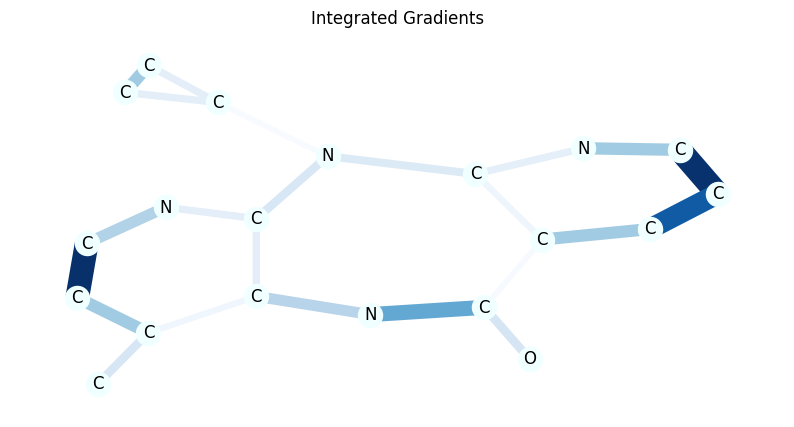

Initial Input Mask: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
Attributions from Saliency: tensor([0.1108, 0.8786, 2.2074, 0.8523, 1.2975, 0.4504, 2.1869, 2.2120, 0.6149,
        1.3121, 1.5283, 2.3806, 4.2229, 1.3960, 3.1658, 0.1004, 0.5649, 2.0607,
        0.0940, 2.6534, 2.0733, 0.0757, 2.6626, 4.2638, 0.3089, 1.2698, 0.6804,
        0.7185, 0.4968, 0.4968, 4.3700, 3.1108, 2.4540, 0.0257, 2.7979, 1.5201,
        0.1732, 1.3418, 1.4942, 0.2094, 2.3725, 1.9584, 1.5897, 0.3599, 0.7185,
        0.6804])
Absolute Edge Mask: [0.11078441 0.8786192  2.207397   0.8523275  1.2974551  0.45037162
 2.186929   2.2119775  0.61489785 1.3120785  1.5283163  2.3805768
 4.222904   1.3959657  3.1658018  0.10040271 0.5649077  2.0607276
 0.09404784 2.6534243  2.0732768  0.07574576 2.6626453  4.2638383
 0.30892098 1.2698222

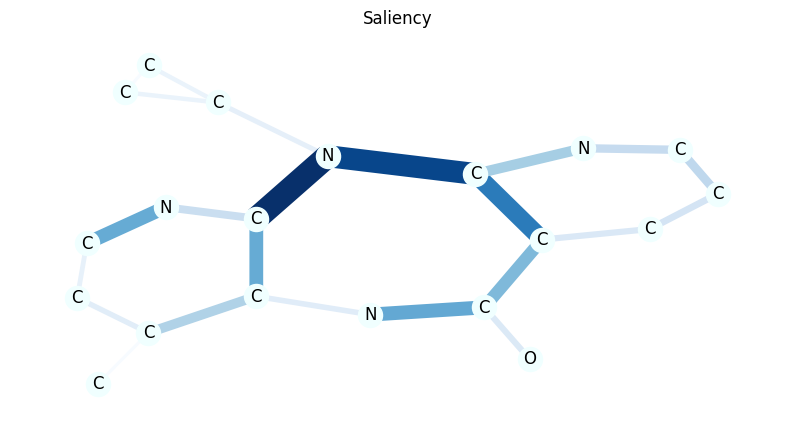

In [39]:
import random
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

# Function to aggregate edge directions
def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

# Custom function to filter out missing data
def filter_existing_data(dataset):
    existing_data = []
    for i in range(len(dataset)):
        try:
            data = dataset.get(i)
            if data is not None:
                existing_data.append(data)
        except FileNotFoundError:
            print(f"File not found for index {i}, skipping.")
    return existing_data

# Filter test_dataset to only include existing data
filtered_test_dataset = filter_existing_data(test_dataset)

# Sample a molecule once from the filtered test dataset
data = random.choice([t for t in filtered_test_dataset if not t.y.item()])
mol = to_molecule(data, ATOM_MAP)
print(f"SMILES formula: {data.smiles}")

# Precompute the layout for consistent drawing
def compute_layout(mol):
    g = mol.copy().to_undirected()
    return nx.spring_layout(g)

layout = compute_layout(mol)

# Updated draw_molecule function to use the precomputed layout
def draw_molecule(g, edge_mask=None, draw_edge_labels=False, layout=None):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    
    if layout is None:
        pos = nx.spring_layout(g)
    else:
        pos = layout
    
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
        
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()

# Use the same molecule and layout for both methods
for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=1)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict, layout=layout)


In [48]:
def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, (u, v) in zip(edge_mask, data.edge_index.t().tolist()):
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    
    # Identify isolated nodes and remove them from the graph
    isolated_nodes = list(nx.isolates(g))
    g.remove_nodes_from(isolated_nodes)
    
    # Prepare node labels
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    
    # Generate positions for the nodes
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    
    # Set edge colors and widths
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    
    # Draw the graph
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    # Draw edge labels if required
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_color='red')
    
    # Show the plot
    plt.show()

Chosen molecule SMILES: [H][C@@]12CC[C@](C)(O)[C@@]1(C)CC[C@@]1([H])[C@@]2([H])CC[C@@]2([H])CC(=O)OC[C@]12C
Integrated Gradients Method - Influential Edges:
Edge (15, 16) with importance 1.0000 connecting C-C
Edge (16, 18) with importance 0.9153 connecting C-O
Edge (16, 17) with importance 0.8704 connecting C-O
Edge (3, 5) with importance 0.8681 connecting C-O
Edge (20, 19) with importance 0.8622 connecting C-C
Edge (12, 13) with importance 0.8462 connecting C-C
Edge (16, 15) with importance 0.8051 connecting C-C
Edge (9, 8) with importance 0.7877 connecting C-C
Edge (2, 1) with importance 0.7811 connecting C-C
Edge (8, 9) with importance 0.7717 connecting C-C
Integrated Gradients Method - Influential Nodes:
Node 1 (C)
Node 2 (C)
Node 3 (C)
Node 5 (O)
Node 8 (C)
Node 9 (C)
Node 12 (C)
Node 13 (C)
Node 15 (C)
Node 16 (C)
Node 17 (O)
Node 18 (O)
Node 19 (C)
Node 20 (C)


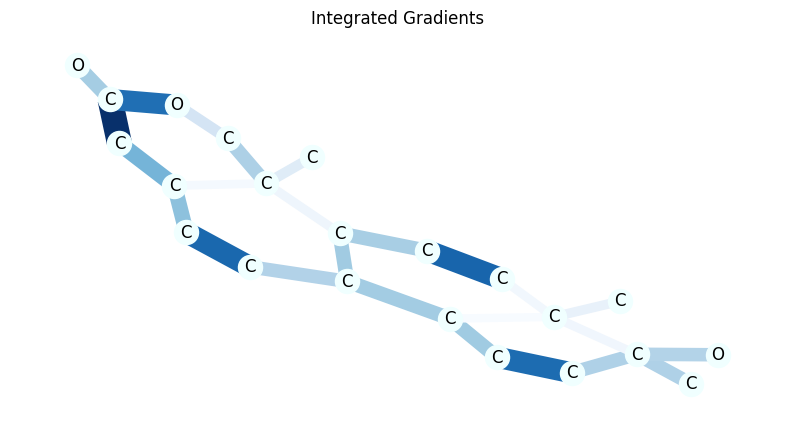

Saliency Method - Influential Edges:
Edge (19, 20) with importance 1.0000 connecting C-C
Edge (15, 14) with importance 0.8240 connecting C-C
Edge (21, 20) with importance 0.7807 connecting C-C
Edge (7, 6) with importance 0.7452 connecting C-C
Edge (14, 20) with importance 0.6909 connecting C-C
Edge (18, 19) with importance 0.6455 connecting O-C
Edge (13, 14) with importance 0.6190 connecting C-C
Edge (4, 3) with importance 0.4698 connecting C-C
Edge (10, 20) with importance 0.4600 connecting C-C
Edge (3, 6) with importance 0.4249 connecting C-C
Saliency Method - Influential Nodes:
Node 3 (C)
Node 4 (C)
Node 6 (C)
Node 7 (C)
Node 10 (C)
Node 13 (C)
Node 14 (C)
Node 15 (C)
Node 18 (O)
Node 19 (C)
Node 20 (C)
Node 21 (C)


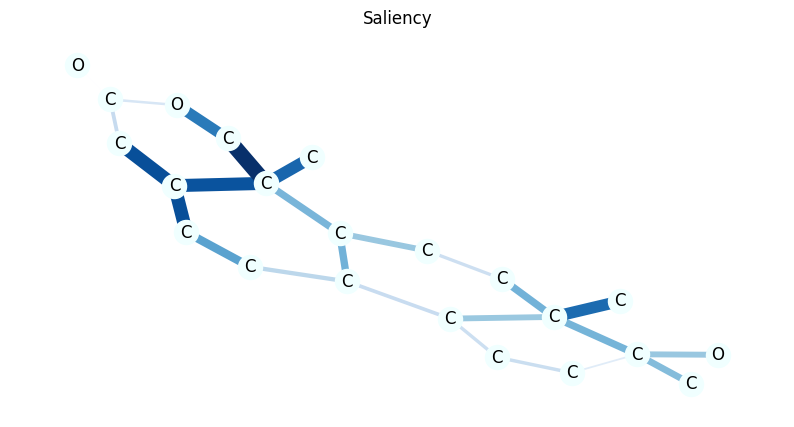

In [51]:

# Example usage with a random molecule from the dataset
#data = random.choice([t for t in test_dataset if not t.y.item()])
data = valid_data[507]
print(f"Chosen molecule SMILES: {data.smiles}")

mol = to_molecule(data, ATOM_MAP)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask, influential_edges, influential_nodes = explain(method, data, target=1)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    
    # Print influential edges and nodes
    print(f"{title} Method - Influential Edges:")
    for u, v, val in influential_edges:
        atom_u = mol.nodes[u]['name']
        atom_v = mol.nodes[v]['name']
        print(f"Edge ({u}, {v}) with importance {val:.4f} connecting {atom_u}-{atom_v}")

    print(f"{title} Method - Influential Nodes:")
    for node in influential_nodes:
        atom = mol.nodes[node]['name']
        print(f"Node {node} ({atom})")
    
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)

Integrated Gradients Method - Influential Edges:
Edge (15, 16) with importance 1.0000 connecting C-C
Edge (16, 18) with importance 0.9153 connecting C-O
Edge (16, 17) with importance 0.8704 connecting C-O
Edge (3, 5) with importance 0.8681 connecting C-O
Edge (20, 19) with importance 0.8622 connecting C-C
Edge (12, 13) with importance 0.8462 connecting C-C
Edge (16, 15) with importance 0.8051 connecting C-C
Edge (9, 8) with importance 0.7877 connecting C-C
Edge (2, 1) with importance 0.7811 connecting C-C
Edge (8, 9) with importance 0.7717 connecting C-C
Integrated Gradients Method - Influential Nodes:
Node 1 (C)
Node 2 (C)
Node 3 (C)
Node 5 (O)
Node 8 (C)
Node 9 (C)
Node 12 (C)
Node 13 (C)
Node 15 (C)
Node 16 (C)
Node 17 (O)
Node 18 (O)
Node 19 (C)
Node 20 (C)


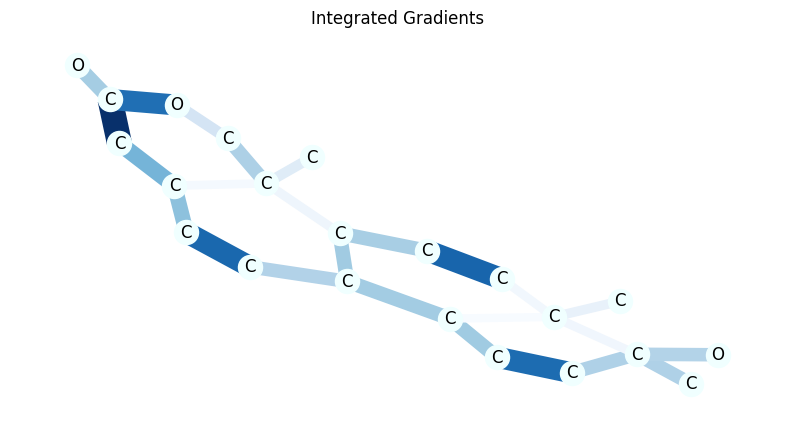

Saliency Method - Influential Edges:
Edge (19, 20) with importance 1.0000 connecting C-C
Edge (15, 14) with importance 0.8240 connecting C-C
Edge (21, 20) with importance 0.7807 connecting C-C
Edge (7, 6) with importance 0.7452 connecting C-C
Edge (14, 20) with importance 0.6909 connecting C-C
Edge (18, 19) with importance 0.6455 connecting O-C
Edge (13, 14) with importance 0.6190 connecting C-C
Edge (4, 3) with importance 0.4698 connecting C-C
Edge (10, 20) with importance 0.4600 connecting C-C
Edge (3, 6) with importance 0.4249 connecting C-C
Saliency Method - Influential Nodes:
Node 3 (C)
Node 4 (C)
Node 6 (C)
Node 7 (C)
Node 10 (C)
Node 13 (C)
Node 14 (C)
Node 15 (C)
Node 18 (O)
Node 19 (C)
Node 20 (C)
Node 21 (C)


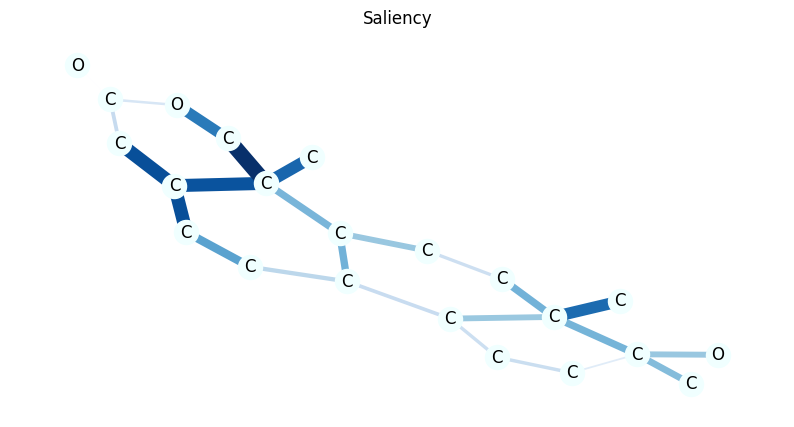

In [50]:
for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask, influential_edges, influential_nodes = explain(method, data, target=1)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    
    # Print influential edges and nodes
    print(f"{title} Method - Influential Edges:")
    for u, v, val in influential_edges:
        atom_u = mol.nodes[u]['name']
        atom_v = mol.nodes[v]['name']
        print(f"Edge ({u}, {v}) with importance {val:.4f} connecting {atom_u}-{atom_v}")

    print(f"{title} Method - Influential Nodes:")
    for node in influential_nodes:
        atom = mol.nodes[node]['name']
        print(f"Node {node} ({atom})")
    
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)

Chosen molecule SMILES: C[C@H](CCCC(C)(C)O)[C@@]1([H])CC[C@@]2([H])\C(CCC[C@]12C)=C\C=C1\C[C@@H](O)CCC1=C
Integrated Gradients Method - Influential Edges:
Edge (6, 5) with importance 1.0000 connecting C-C
Edge (7, 5) with importance 1.0000 connecting C-C
Edge (8, 5) with importance 1.0000 connecting C-C
Edge (3, 4) with importance 0.9186 connecting C-C
Edge (9, 17) with importance 0.8073 connecting C-O
Edge (12, 17) with importance 0.8055 connecting C-O
Edge (5, 4) with importance 0.6319 connecting C-C
Edge (18, 17) with importance 0.6114 connecting C-O
Edge (15, 16) with importance 0.4497 connecting C-O
Edge (17, 18) with importance 0.3509 connecting O-C
Integrated Gradients Method - Influential Nodes:
Node 3 (C)
Node 4 (C)
Node 5 (C)
Node 6 (C)
Node 7 (C)
Node 8 (C)
Node 9 (C)
Node 12 (C)
Node 15 (C)
Node 16 (O)
Node 17 (O)
Node 18 (C)


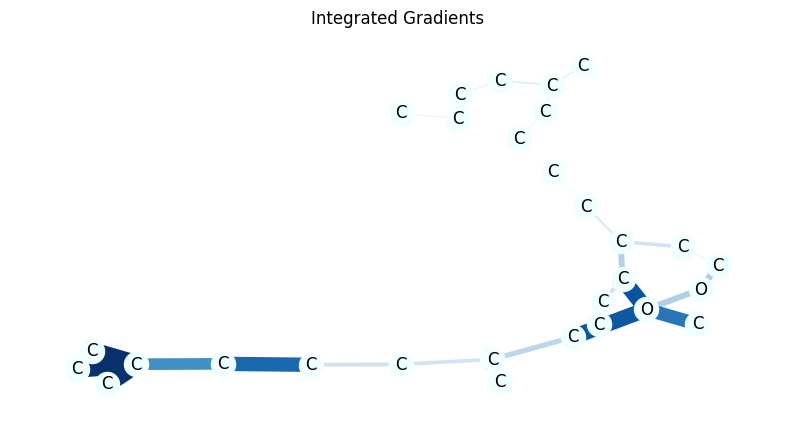

Saliency Method - Influential Edges:
Edge (12, 17) with importance 1.0000 connecting C-O
Edge (9, 17) with importance 0.9855 connecting C-O
Edge (17, 12) with importance 0.8582 connecting O-C
Edge (17, 9) with importance 0.7993 connecting O-C
Edge (13, 12) with importance 0.6761 connecting C-C
Edge (12, 13) with importance 0.6520 connecting C-C
Edge (11, 12) with importance 0.5673 connecting C-C
Edge (1, 9) with importance 0.5526 connecting C-C
Edge (18, 17) with importance 0.5271 connecting C-O
Edge (16, 17) with importance 0.4964 connecting O-O
Saliency Method - Influential Nodes:
Node 1 (C)
Node 9 (C)
Node 11 (C)
Node 12 (C)
Node 13 (C)
Node 16 (O)
Node 17 (O)
Node 18 (C)


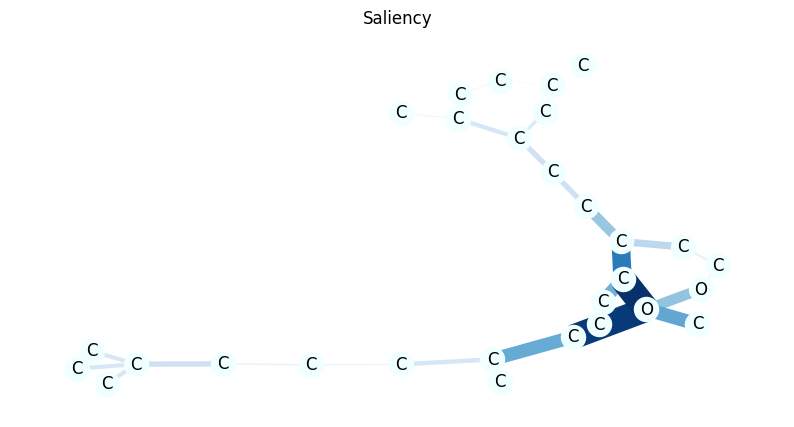

In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import Saliency, IntegratedGradients
from collections import defaultdict
import random
from torch_geometric.utils import to_networkx

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out

def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    
    # Get influential edges
    edge_influence = [(u.item(), v.item(), val) for val, u, v in zip(edge_mask, *data.edge_index)]
    edge_influence.sort(key=lambda x: x[2], reverse=True)
    influential_edges = edge_influence[:10]  # Top 10 influential edges

    # Get influential nodes
    influential_nodes = set()
    for u, v, val in influential_edges:
        influential_nodes.add(u)
        influential_nodes.add(v)
    
    return edge_mask, influential_edges, influential_nodes

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, (u, v) in zip(edge_mask, data.edge_index.t().tolist()):
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    
    # Identify isolated nodes and remove them from the graph
    isolated_nodes = list(nx.isolates(g))
    g.remove_nodes_from(isolated_nodes)
    
    # Prepare node labels
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    
    # Generate positions for the nodes
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    
    # Set edge colors and widths
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    
    # Draw the graph
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    # Draw edge labels if required
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_color='red')
    
    # Show the plot
    plt.show()

def to_molecule(data):
    ATOM_MAP = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 
            'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'V', 'Cr', 
            'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 
            'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 
            'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 
            'Ba', 'La', 'Ce', 'Nd', 'Sm', 'Gd', 'Ho', 'Lu', 'Hf', 'Ta', 
            'W', 'Re', 'Os', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ra', 'Ac', 'Bk']
    
    g = to_networkx(data, node_attrs=['x'])
    
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    
    return g

# Example usage with a random molecule from the dataset
data = random.choice([t for t in test_dataset if not t.y.item()])
print(f"Chosen molecule SMILES: {data.smiles}")

mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask, influential_edges, influential_nodes = explain(method, data, target=1)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    
    # Print influential edges and nodes
    print(f"{title} Method - Influential Edges:")
    for u, v, val in influential_edges:
        atom_u = mol.nodes[u]['name']
        atom_v = mol.nodes[v]['name']
        print(f"Edge ({u}, {v}) with importance {val:.4f} connecting {atom_u}-{atom_v}")

    print(f"{title} Method - Influential Nodes:")
    for node in influential_nodes:
        atom = mol.nodes[node]['name']
        print(f"Node {node} ({atom})")
    
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)


Chosen molecule SMILES: CC1CC2=CC=CC=C2N1NC(=O)C1=CC(=C(Cl)C=C1)S(N)(=O)=O
Integrated Gradients Method - Influential Edges:
Edge (22, 20) with importance 1.0000 connecting C-N
Edge (23, 20) with importance 1.0000 connecting C-N
Edge (15, 20) with importance 0.9068 connecting C-N
Edge (20, 15) with importance 0.7198 connecting N-C
Edge (13, 11) with importance 0.7169 connecting C-C
Edge (12, 11) with importance 0.6940 connecting C-C
Edge (9, 10) with importance 0.6198 connecting C-C
Edge (16, 18) with importance 0.6034 connecting C-N
Edge (19, 18) with importance 0.5516 connecting N-N
Edge (15, 14) with importance 0.5343 connecting C-C
Integrated Gradients Method - Influential Nodes:
Node 9 (C)
Node 10 (C)
Node 11 (C)
Node 12 (C)
Node 13 (C)
Node 14 (C)
Node 15 (C)
Node 16 (C)
Node 18 (N)
Node 19 (N)
Node 20 (N)
Node 22 (C)
Node 23 (C)


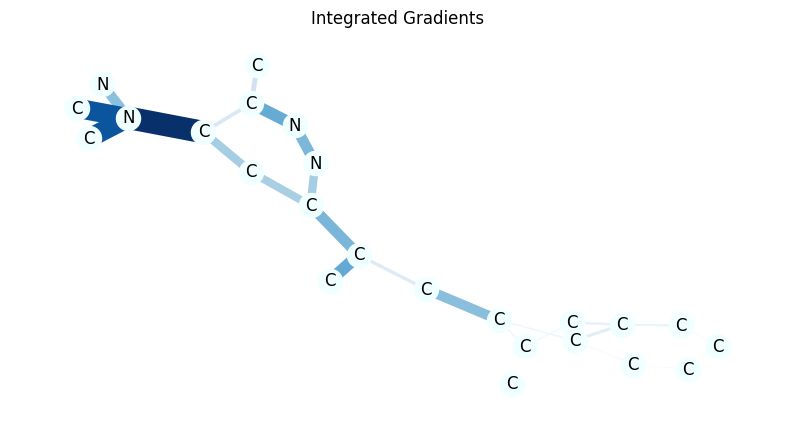

Saliency Method - Influential Edges:
Edge (20, 15) with importance 1.0000 connecting N-C
Edge (8, 9) with importance 0.8021 connecting C-C
Edge (9, 8) with importance 0.7236 connecting C-C
Edge (9, 1) with importance 0.7192 connecting C-C
Edge (1, 9) with importance 0.6748 connecting C-C
Edge (3, 8) with importance 0.6646 connecting C-C
Edge (8, 3) with importance 0.6068 connecting C-C
Edge (10, 9) with importance 0.5336 connecting C-C
Edge (7, 8) with importance 0.4807 connecting C-C
Edge (3, 2) with importance 0.4586 connecting C-C
Saliency Method - Influential Nodes:
Node 1 (C)
Node 2 (C)
Node 3 (C)
Node 7 (C)
Node 8 (C)
Node 9 (C)
Node 10 (C)
Node 15 (C)
Node 20 (N)


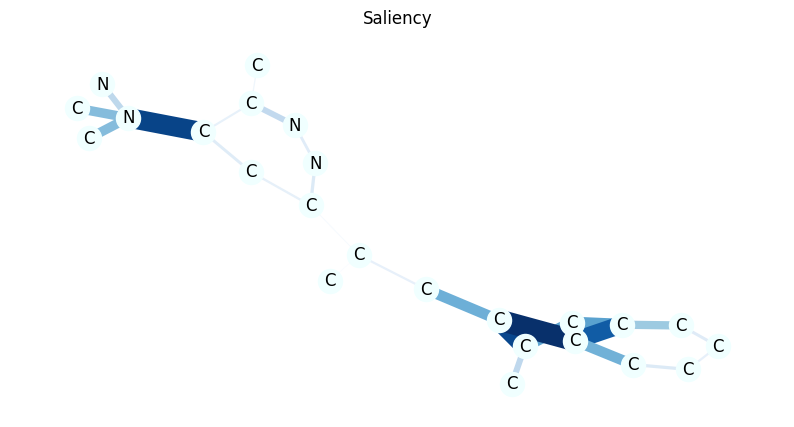

In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import Saliency, IntegratedGradients
from collections import defaultdict
import random
from torch_geometric.utils import to_networkx

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out

def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    
    # Get influential edges
    edge_influence = [(u.item(), v.item(), val) for val, u, v in zip(edge_mask, *data.edge_index)]
    edge_influence.sort(key=lambda x: x[2], reverse=True)
    influential_edges = edge_influence[:10]  # Top 10 influential edges

    # Get influential nodes
    influential_nodes = set()
    for u, v, val in influential_edges:
        influential_nodes.add(u)
        influential_nodes.add(v)
    
    return edge_mask, influential_edges, influential_nodes

def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, (u, v) in zip(edge_mask, data.edge_index.t().tolist()):
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    
    # Identify isolated nodes and remove them from the graph
    isolated_nodes = list(nx.isolates(g))
    g.remove_nodes_from(isolated_nodes)
    
    # Prepare node labels
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    
    # Generate positions for the nodes
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    
    # Set edge colors and widths
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    
    # Draw the graph
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    # Draw edge labels if required
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_color='red')
    
    # Show the plot
    plt.show()

def to_molecule(data):
    ATOM_MAP = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 
            'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'V', 'Cr', 
            'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 
            'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 
            'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 
            'Ba', 'La', 'Ce', 'Nd', 'Sm', 'Gd', 'Ho', 'Lu', 'Hf', 'Ta', 
            'W', 'Re', 'Os', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ra', 'Ac', 'Bk']
    
    g = to_networkx(data, node_attrs=['x'])
    
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    
    return g

# Filter the test dataset to only include samples with target label 1 (doping drugs)
doping_samples = [t for t in test_dataset if t.y.item() == 1]

# Check if there are any doping samples available
if doping_samples:
    data = random.choice(doping_samples)
    print(f"Chosen molecule SMILES: {data.smiles}")

    mol = to_molecule(data)

    for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
        edge_mask, influential_edges, influential_nodes = explain(method, data, target=1)
        edge_mask_dict = aggregate_edge_directions(edge_mask, data)
        
        # Print influential edges and nodes
        print(f"{title} Method - Influential Edges:")
        for u, v, val in influential_edges:
            atom_u = mol.nodes[u]['name']
            atom_v = mol.nodes[v]['name']
            print(f"Edge ({u}, {v}) with importance {val:.4f} connecting {atom_u}-{atom_v}")

        print(f"{title} Method - Influential Nodes:")
        for node in influential_nodes:
            atom = mol.nodes[node]['name']
            print(f"Node {node} ({atom})")
        
        plt.figure(figsize=(10, 5))
        plt.title(title)
        draw_molecule(mol, edge_mask_dict)
else:
    print("No doping samples found in the test dataset.")


Chosen molecule SMILES: CN(C)CCOC(C1=CC=C(Cl)C=C1)C1=CC=CC=N1
Integrated Gradients Method - Influential Edges:
Edge (9, 10) with importance 1.0000 connecting C-O
Edge (12, 10) with importance 1.0000 connecting C-O
Edge (1, 2) with importance 0.5324 connecting C-N
Edge (11, 10) with importance 0.3678 connecting O-O
Edge (1, 3) with importance 0.3642 connecting C-N
Edge (4, 3) with importance 0.3548 connecting C-N
Edge (6, 7) with importance 0.2638 connecting C-C
Edge (7, 8) with importance 0.2613 connecting C-C
Edge (7, 13) with importance 0.2613 connecting C-C
Edge (14, 6) with importance 0.1902 connecting C-C
Integrated Gradients Method - Influential Nodes:
Node 1 (C)
Node 2 (N)
Node 3 (N)
Node 4 (C)
Node 6 (C)
Node 7 (C)
Node 8 (C)
Node 9 (C)
Node 10 (O)
Node 11 (O)
Node 12 (C)
Node 13 (C)
Node 14 (C)


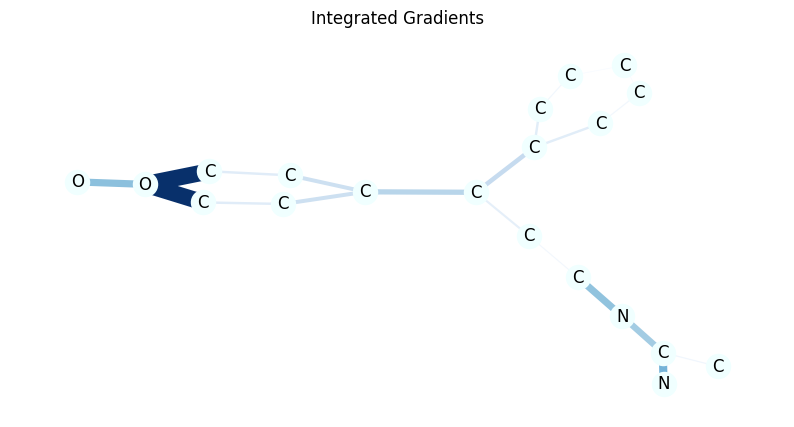

Saliency Method - Influential Edges:
Edge (3, 1) with importance 1.0000 connecting N-C
Edge (0, 1) with importance 0.9849 connecting C-C
Edge (2, 1) with importance 0.8539 connecting N-C
Edge (10, 9) with importance 0.6988 connecting O-C
Edge (10, 12) with importance 0.6988 connecting O-C
Edge (1, 0) with importance 0.6228 connecting C-C
Edge (1, 3) with importance 0.5101 connecting C-N
Edge (4, 3) with importance 0.4770 connecting C-N
Edge (11, 10) with importance 0.4487 connecting O-O
Edge (10, 11) with importance 0.4231 connecting O-O
Saliency Method - Influential Nodes:
Node 0 (C)
Node 1 (C)
Node 2 (N)
Node 3 (N)
Node 4 (C)
Node 9 (C)
Node 10 (O)
Node 11 (O)
Node 12 (C)


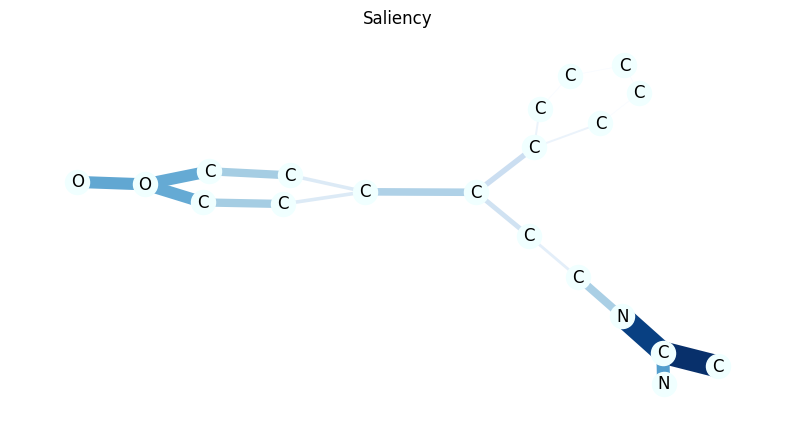

Total: 1192, Correct: 1056, Accuracy: 0.8859
TP: 26, TN: 1030, FP: 1, FN: 135
TP Rate: 0.1615, TN Rate: 0.9990, FP Rate: 0.0010, FN Rate: 0.8385


In [58]:
def test(loader, target_class=1):
    model.eval()
    correct = 0
    total = 0
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        
        # Count total correct predictions
        correct += pred.eq(data.y).sum().item()
        total += data.y.size(0)
        
        # Calculate TP, TN, FP, FN
        for i in range(data.y.size(0)):
            if pred[i] == target_class and data.y[i] == target_class:
                tp += 1
            elif pred[i] == target_class and data.y[i] != target_class:
                fp += 1
            elif pred[i] != target_class and data.y[i] == target_class:
                fn += 1
            elif pred[i] != target_class and data.y[i] != target_class:
                tn += 1

    accuracy = correct / total
    tp_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
    tn_rate = tn / (tn + fp) if (tn + fp) > 0 else 0
    fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

    print(f'Total: {total}, Correct: {correct}, Accuracy: {accuracy:.4f}')
    print(f'TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')
    print(f'TP Rate: {tp_rate:.4f}, TN Rate: {tn_rate:.4f}, FP Rate: {fp_rate:.4f}, FN Rate: {fn_rate:.4f}')

    return accuracy, tp, tn, fp, fn

# Example usage with a random molecule from the dataset
data = random.choice([t for t in test_dataset if not t.y.item()])
print(f"Chosen molecule SMILES: {data.smiles}")

mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask, influential_edges, influential_nodes = explain(method, data, target=1)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    
    # Print influential edges and nodes
    print(f"{title} Method - Influential Edges:")
    for u, v, val in influential_edges:
        atom_u = mol.nodes[u]['name']
        atom_v = mol.nodes[v]['name']
        print(f"Edge ({u}, {v}) with importance {val:.4f} connecting {atom_u}-{atom_v}")

    print(f"{title} Method - Influential Nodes:")
    for node in influential_nodes:
        atom = mol.nodes[node]['name']
        print(f"Node {node} ({atom})")
    
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict)

# Test the model on the test dataset and print TP, TN, FP, FN rates
test_loader = DataLoader(test_dataset, batch_size=128)
accuracy, tp, tn, fp, fn = test(test_loader, target_class=1)